<a href="https://colab.research.google.com/github/Anyaoma/My-projects/blob/main/Lewis_Approach_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import brute, fmin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

## Heston model application OOP

$$
\begin{align*}
dS_t &= \mu S_t \, dt + \sqrt{v_t} S_t \, dW_t^S, \\
dv_t &= \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v, \\
dW_t^S dW_t^v &= \rho \, dt.
\end{align*}
$$

## lewis (2001) approach to call pricing under heston

\### Lewis (2001) Call Price Formula
$$
C_0 = S_0 - \sqrt{\frac{S_0 K e^{-rT}}{\pi}} \int_0^{\infty} \frac{\Re \left[ e^{izk} \phi(z - i/2) \right]}{z^2 + \frac{1}{4}} \, dz
$$

### Heston (1993) Characteristic Function
$$
\phi_H(u, T) = \exp \left( H_1(u, T) + H_2(u, T) \nu_0 \right)
$$

#### Components of the Characteristic Function
$$
H_1(u, T) \equiv r_0 u i T + \frac{c_1}{\sigma^2_{\nu}} \left[ (\kappa_{\nu} - \rho \sigma_{\nu} u i + c_2) T - 2 \log \left( \frac{1 - c_3 e^{c_2 T}}{1 - c_3} \right) \right]
$$

$$
H_2(u, T) \equiv \frac{\kappa_{\nu} - \rho \sigma_{\nu} u i + c_2}{\sigma^2_{\nu}} \left[ \frac{1 - e^{c_2 T}}{1 - c_3 e^{c_2 T}} \right]
$$

#### Definitions of the Constants
$$
c_1 \equiv \kappa_{\nu} \theta_{\nu}
$$

$$
c_2 \equiv - \sqrt{(\rho \sigma_{\nu} u i - \kappa_{\nu})^2 - \sigma^2_{\nu} (-u i - u^2)}
$$

$$
c_3 \equiv \frac{\kappa_{\nu} - \rho \sigma_{\nu} u i + c_2}{\kappa_{\nu} - \rho \sigma_{\nu} u i - c_2}
$$


In [ ]:
data = pd.DataFrame({
    'Strike': [227.5, 230, 232.5, 235.0, 237.5, 227.5, 230.0, 232.5, 235.0, 237.5],
    'T': [15 / 250] * 10,  # Time to maturity (15 days, assuming 250 trading days per year),
    'Price': [10.52, 10.05, 7.75, 6.01, 4.75, 4.32, 5.20, 6.45, 7.56, 8.78],  # Call prices,
    'Type': ['C','C','C','C','C','P','P','P','P','P'],
    'r':[0.015]*10,

})

In [ ]:
data

,Strike,T,Price,Type,r
0,227.5,0.06,10.52,C,0.015
1,230.0,0.06,10.05,C,0.015
2,232.5,0.06,7.75,C,0.015
3,235.0,0.06,6.01,C,0.015
4,237.5,0.06,4.75,C,0.015
5,227.5,0.06,4.32,P,0.015
6,230.0,0.06,5.20,P,0.015
7,232.5,0.06,6.45,P,0.015
8,235.0,0.06,7.56,P,0.015
9,237.5,0.06,8.78,P,0.015


In [ ]:
i= 0
min_MSE = 500

In [ ]:

def characteristic_function(u, r, T, kappa, theta, sigma, rho, v0):
    c1 = kappa * theta

    c2 = -np.sqrt((rho * sigma * u * 1j - kappa) ** 2 - sigma ** 2 * (-u ** 2 - 1j * u))

    c3 = (kappa - rho * sigma * u * 1j + c2) / (kappa - rho * sigma * u * 1j - c2)

    H1 = r * 1j * u * T + (c1 / sigma ** 2) * ((kappa - rho * sigma * u * 1j + c2) * T - 2 * np.log((1 - c3*np.exp(c2 * T)) / (1 - c3)))

    H2 = ((kappa - rho * sigma * u * 1j + c2) / sigma**2) * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))

    return np.exp(H1 + H2 * v0)

def integral_value(u, r, T, kappa, theta, sigma, rho, v0, S0, K):
    char_f = characteristic_function(u - 1j * 0.5, r, T, kappa, theta, sigma, rho, v0)
    int_value = 1/(u**2 + 0.25) * (np.exp(1j * u * np.log(S0/K)) * char_f).real
    return int_value

def call_value(r, T, kappa, theta, sigma, rho, v0, S0, K):
    int_value = quad(lambda u: integral_value(u, r, T, kappa, theta, sigma, rho, v0, S0, K ),0,np.inf, limit=500)[0]

    call_value =  max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)

    return call_value



def error_function(p0):
    ''' error function to be minimized
    '''
    global min_MSE, i
    # Initial parameters for kappa_v, theta_v, sigma_v, rho, v0

    kappa, theta, sigma, rho, v0 = p0
    mse = []

    for _, option in data.iterrows():
        if option['Type'] == 'C':
           model_price = call_value(option['r'], option['T'], kappa, theta, sigma, rho, v0, 232.90, option['Strike'])
           mse.append((model_price - option['Price'])**2)
        else:
            call_price = call_value(option['r'], option['T'], kappa, theta, sigma, rho, v0, 232.90, option['Strike'])
            present_value_strike = option['Strike'] * np.exp(-option['r']*option['T'])
            model_price = call_price  - 232.90 + present_value_strike
            mse.append((model_price - option['Price'])**2)

    mean_mse = np.mean(mse)
    min_ = min(min_MSE, mean_mse)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (mean_mse, min_))
    i += 1
    return mean_mse


    return np.mean(mse)
    # Error function for calibration

def calibration(p0=[1.5, 0.02, 0.15, 0.1, 0.01]):
    ''' calibration function
    '''
        # Initial parameters for kappa_v, theta_v, sigma_v, rho, v0
    opt_params = minimize(error_function, p0, bounds=[(0, None), (0, None), (0, None), (-1, 1), (0, None)])
    return opt_params.x


def full_model_calibration():
    ''' model calibration
    '''
    model_values = []
    kappa, theta, sigma, rho, v0 = calibration()

    for _, option in data.iterrows():
        if option['Type'] == 'C':
           model_price = call_value(option['r'], option['T'], kappa, theta, sigma, rho, v0, 232.90, option['Strike'])
           model_values.append(model_price)
        else:
            call_price = call_value(option['r'], option['T'], kappa, theta, sigma, rho, v0, 232.90, option['Strike'])
            present_value_strike = option['Strike'] * np.exp(-option['r']*option['T'])
            model_price = call_price  - 232.90 + present_value_strike
            model_values.append(model_price)

    data['Model Price'] = model_values
    return data




In [ ]:
dataset = full_model_calibration()

   0 | [1.5  0.02 0.15 0.1  0.01] |  19.813 |  19.813
  25 | [1.50003359 0.02429454 0.14998105 0.09998134 0.10363771] |   0.384 |   0.384
  50 | [1.50004569 0.02403696 0.14993646 0.09991027 0.09797779] |   0.347 |   0.347
  75 | [1.50005116 0.02408987 0.14720435 0.09582922 0.09774972] |   0.347 |   0.347
 100 | [ 1.50018946  0.02578088  0.07290566 -0.0151941   0.0970699 ] |   0.345 |   0.345
 125 | [ 1.50102158  0.02678016  0.08580915 -0.1365177   0.09848892] |   0.343 |   0.343


<ipython-input-5-7641852501c8>:20: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: integral_value(u, r, T, kappa, theta, sigma, rho, v0, S0, K ),0,np.inf, limit=500)[0]


 150 | [1.48241358 0.         2.3702436  1.         0.07449279] |   6.176 |   6.176
 175 | [ 1.51753705  0.01666492  1.80684078 -0.87769313  0.11264471] |   0.262 |   0.262
 200 | [ 1.51642564  0.01626825  1.65203484 -0.72540356  0.11150679] |   0.248 |   0.248
 225 | [ 1.50791038  0.02634135  1.04437857 -1.          0.10179686] |   0.248 |   0.248
 250 | [ 1.51019681  0.02379772  1.21514034 -0.99999999  0.10454133] |   0.246 |   0.246
 275 | [ 1.5100897   0.02394961  1.20728368 -1.          0.10441633] |   0.246 |   0.246


In [ ]:
dataset

,Strike,T,Price,Type,r,Model Price
0,227.5,0.06,10.52,C,0.015,10.511968
1,230.0,0.06,10.05,C,0.015,8.859146
2,232.5,0.06,7.75,C,0.015,7.321221
3,235.0,0.06,6.01,C,0.015,5.907725
4,237.5,0.06,4.75,C,0.015,4.627755
5,227.5,0.06,4.32,P,0.015,4.907310
6,230.0,0.06,5.20,P,0.015,5.752239
7,232.5,0.06,6.45,P,0.015,6.712065
8,235.0,0.06,7.56,P,0.015,7.796320
9,237.5,0.06,8.78,P,0.015,9.014101


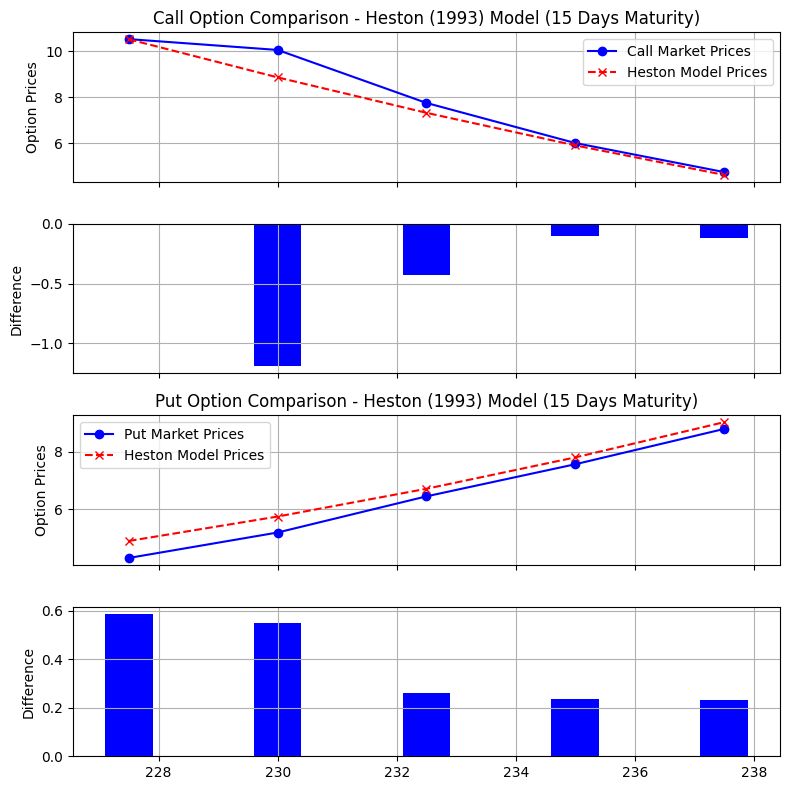

In [ ]:
# Calculate differences and percentage differences
dataset['Difference'] = dataset['Model Price'] - dataset['Price']
dataset['Percentage Difference'] = (dataset['Difference'] / dataset['Price']) * 100

# Plot Market vs Model Prices
fig, axs = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

call_options = dataset[dataset['Type'] == 'C']
put_options = dataset[dataset['Type'] == 'P']

# Plot 1: Market vs Model Prices
axs[0].plot(call_options['Strike'], call_options['Price'], label='Call Market Prices', marker='o', color='blue')
axs[0].plot(call_options['Strike'], call_options['Model Price'], label='Heston Model Prices', marker='x', color='red', linestyle='--')
axs[0].set_ylabel("Option Prices")
axs[0].set_title("Call Option Comparison - Heston (1993) Model (15 Days Maturity)")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Difference between Market and Model Prices
axs[1].bar(call_options['Strike'], call_options['Difference'], color='blue')
axs[1].set_ylabel("Difference")
axs[1].grid(True)

# Plot 1: Market vs Model Prices
axs[2].plot(put_options['Strike'], put_options['Price'], label='Put Market Prices', marker='o', color='blue')
axs[2].plot(put_options['Strike'], put_options['Model Price'], label='Heston Model Prices', marker='x', color='red', linestyle='--')
axs[2].set_ylabel("Option Prices")
axs[2].set_title("Put Option Comparison - Heston (1993) Model (15 Days Maturity)")
axs[2].legend()
axs[2].grid(True)

# Plot 2: Difference between Market and Model Prices
axs[3].bar(put_options['Strike'], put_options['Difference'], color='blue')
axs[3].set_ylabel("Difference")
axs[3].grid(True)

plt.tight_layout()
plt.show()